Let's implement structure factor calculations for P1 lattices with a single atom type from scratch. 


The starting point is a crystal with cell constants $A, B, C, \alpha, \beta, \gamma$. The orthogonalization matrix,
$$
O = \begin{bmatrix}a & b\cos\gamma & c \cos\beta\\
0 & b\sin\gamma & \frac {c(\cos\alpha - \cos\beta\cos\gamma} {\sin\gamma} \\
0 & 0 & \frac {V} {ab\sin\gamma}
\end{bmatrix} \\
V = abc\sqrt{1 - \cos^2\alpha - \cos^2\beta -\cos^2\gamma + 2\cos\alpha\cos\beta\cos\gamma},
$$
can be used to convert from fractional to cartesian coordinates. The inverse of this matrix converts from cartesian, x,y,z, coordinates to fractional coordinates in the unit cell basis. 

The resolution of a reflection is
$$
d*_h = \frac {1}{d_h} = |(O^{-1})^Th|
$$

$$
F = \sum_j f_j e^{-2\pi i H\cdot x_j}
$$

In [9]:
%pylab notebook
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


/home/kmdalton/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'beta', 'std', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
a,b,c = 30, 40, 90
alpha,beta,gamma = 90, 90, 90

alpha,beta,gamma = np.deg2rad(alpha),np.deg2rad(beta),np.deg2rad(gamma)
V = a*b*c*np.sqrt(1 - np.cos(alpha)**2-np.cos(beta)**2 - np.cos(gamma)**2 + 
                  2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
O = [
    [a, b*np.cos(gamma), c*np.cos(beta)],
    [0, b*np.sin(gamma), c*(np.cos(alpha) - np.cos(beta)*np.cos(gamma))/np.sin(gamma)],
    [0, 0, V / (a*b*np.sin(gamma))],
]
Oinv = np.linalg.inv(O)
    
alpha,beta,gamma = np.rad2deg(alpha),np.rad2deg(beta),np.rad2deg(gamma)

# Cromer-Mann coefficients for Carbon:

|i | 1 | 2 | 3 | 4 |
|--|---|---|---|---|
|a_i (e-) | 2.310 | 1.020 | 1.589 | 0.865 |
|b_i (A^2)| 20.844 | 10.208 | 0.569 | 51.651 |
|c   (e-)| 0.216 | ----- | ----- | ----- |


$f_j = \sum_{j=1}^4 a_j \cdot e^{-b_i(sin\theta / \lambda)^2+c}$

$\sin \theta/\lambda = \frac {1} {2 d_h}$

# Debye Waller Temperature Factors

$$
f_j^B = f_j \cdot T_j \\
T_j = e^{-B_j(\sin\theta/\lambda)^2}
$$

<IPython.core.display.Javascript object>


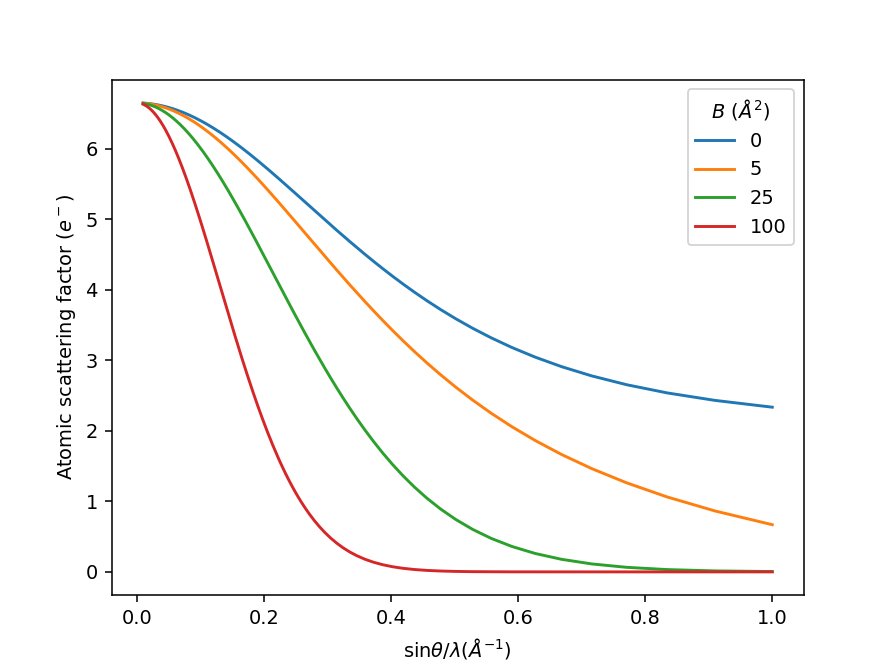

In [3]:
a_cm = np.array([2.310, 1.020, 1.589, 0.865])
b_cm = np.array([20.844, 10.208, 0.569, 51.651])
c_cm = 0.216

d = np.linspace(100, 1., 1000)

f = (a_cm[:,None]*np.exp(-b_cm[:,None]/(4*d*d)) + c_cm).sum(0)
B = np.array([0, 5, 25, 100])
T = np.exp(-B[:,None]/(4*d*d))

f.shape
plt.plot(1./d, (T*f).T)
plt.xlabel(r"$\sin \theta /\lambda (\AA^{-1})$")
plt.ylabel(r"Atomic scattering factor ($e^-$)")
plt.legend(B, title=r'$B\ (\AA^2)$')

# Simulated Time Resolved Crystallography Experiments

The following cell contains code to simulate a very simple time resolved crystallography experiment. This sort of simplistic code has some limitations, but may be useful for reasoning about priors in reciprocal space. 

The way the simulation is set up is that 100 carbon atoms are placed in a P1 unit cell. 1000 times, the coordinates of the atoms are jittered 
$$
X = X_0 + \Delta X \\
\Delta X \sim Laplacian(0, 0.1)
$$
by a displacement drawn from a laplacian distribution. 
The structure factor amplitudes for a random subset of reflections are calculated before and after perturbing the coordinates. The particular expression for the structure factor amplitudes,
$$
F_h = f_j(d_h) T_j e^{-2\pi i H\cdot x},
$$
includes isotropic temperature factors which are drawn from a normal distribution. 
$$
T_j = e^{-B_j / (2d)^2} \\
B_j \sim \max (0, \mathcal{N} (20, 10))
$$


From these equations, the complex $F_{on}$ and $F_{off}$ are computed. 
The complex Fourier difference $\Delta F = F_{on} - F{off}$.

In [4]:
num_particles = 100

#Temperature Factors
B = np.maximum(0, np.random.normal(20, 10, num_particles))

#Std deviation of coordinate jitter
std = 0.1#Angstroms

#Number of jitters to compute
iters = 1000

#Number of sample reflections
reflections=200

#Maximum h,k,l index range
hmax = 30


H = np.random.randint(0, hmax+1, (3, reflections))
while H.sum(0).min() == 0:
    H = np.random.randint(0, hmax+1, (3, reflections))
D = 1./np.linalg.norm(Oinv.T.dot(H), 2, 0)

#Random locations in fractional coordinates
Xoff = np.random.random((num_particles, 3))
#Convert to cartesian
Xoff = np.matmul(Xoff, O)
#Random jitter in cartesian space
DeltaX = np.random.laplace(0., std, (iters, num_particles, 3)) 
Xon = Xoff[None,:,:] + DeltaX

#Convert back to fractional coordinates
Xon = np.matmul(Xon, Oinv)
Xon = np.mod(Xon, 1.)
Xoff = np.matmul(Xoff, Oinv)

#Fourier transform
f = (a_cm[:,None]*np.exp(-b_cm[:,None]/(4*D*D)) + c_cm).sum(0)
T = np.exp(-B[:,None]/(4*D*D))
Foff = (T*f*np.exp(-1j*2*np.pi*Xoff.dot(H))).sum(-2)
Fon = (T*f*np.exp(-1j*2*np.pi*Xon.dot(H))).sum(-2).T
DeltaF = Fon - Foff[:,None]

<IPython.core.display.Javascript object>


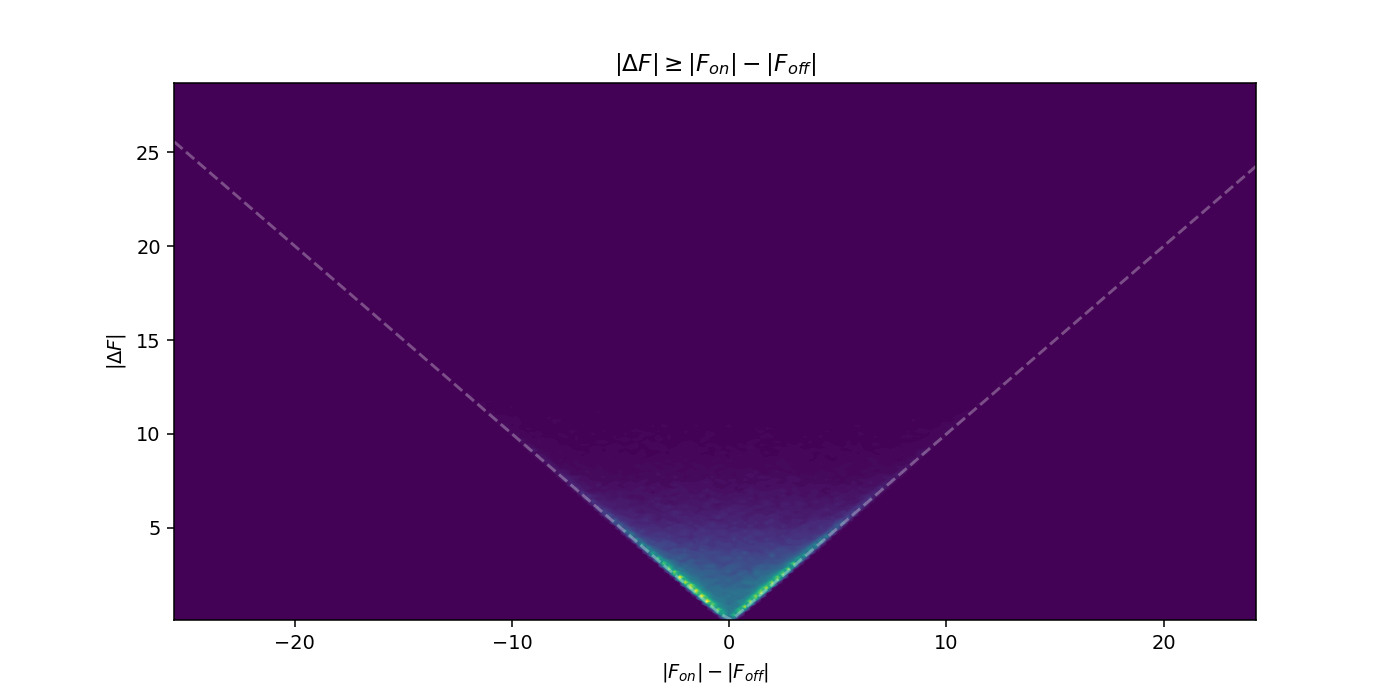

Text(0.5, 1.0, '$|\\Delta F| \\geq |F_{on}| - |F_{off}|$')

In [5]:
z,x,y = np.histogram2d((np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), np.abs(DeltaF).flatten(), 200, normed=True)
x,y = np.meshgrid(0.5*x[1:] + 0.5*x[:-1], 0.5*y[1:] + 0.5*y[:-1])
plt.figure(figsize=(10, 5))
plt.contourf(x, y, z.T, 100)
xmin, xmax= plt.xlim()
plt.plot(np.linspace(xmin, xmax, 100), np.abs(np.linspace(xmin, xmax, 100)), '--w', scalex=False, scaley=False, alpha=0.3)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$|\Delta F|$")
plt.title(r"$|\Delta F| \geq |F_{on}| - |F_{off}|$")

<IPython.core.display.Javascript object>


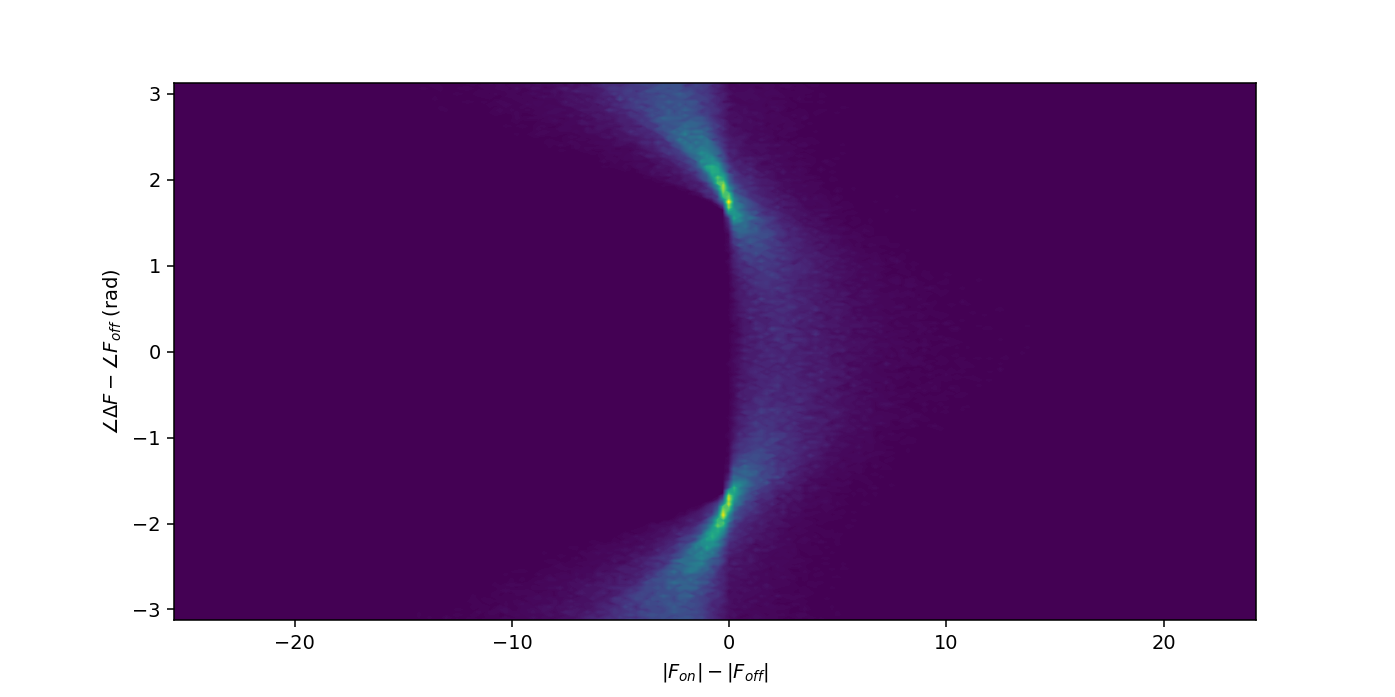

Text(0, 0.5, '$\\angle \\Delta F - \\angle F_{off}$ (rad)')

In [6]:
z, x, y = np.histogram2d(
    (np.abs(Fon) - np.abs(Foff)[:,None]*np.ones(Fon.shape)).flatten(), 
    np.angle(DeltaF*np.exp(-1j*np.angle(Foff))[:,None]).flatten(),
    200,
)
z = z.T
x,y = np.meshgrid(0.5*x[1:] + 0.5*x[:-1], 0.5*y[1:] + 0.5*y[:-1])
plt.figure(figsize=(10, 5))
plt.contourf(x, y, z, 200)
plt.xlabel(r"$|F_{on}| - |F_{off}|$")
plt.ylabel(r"$\angle \Delta F - \angle F_{off}$ (rad)")

<IPython.core.display.Javascript object>


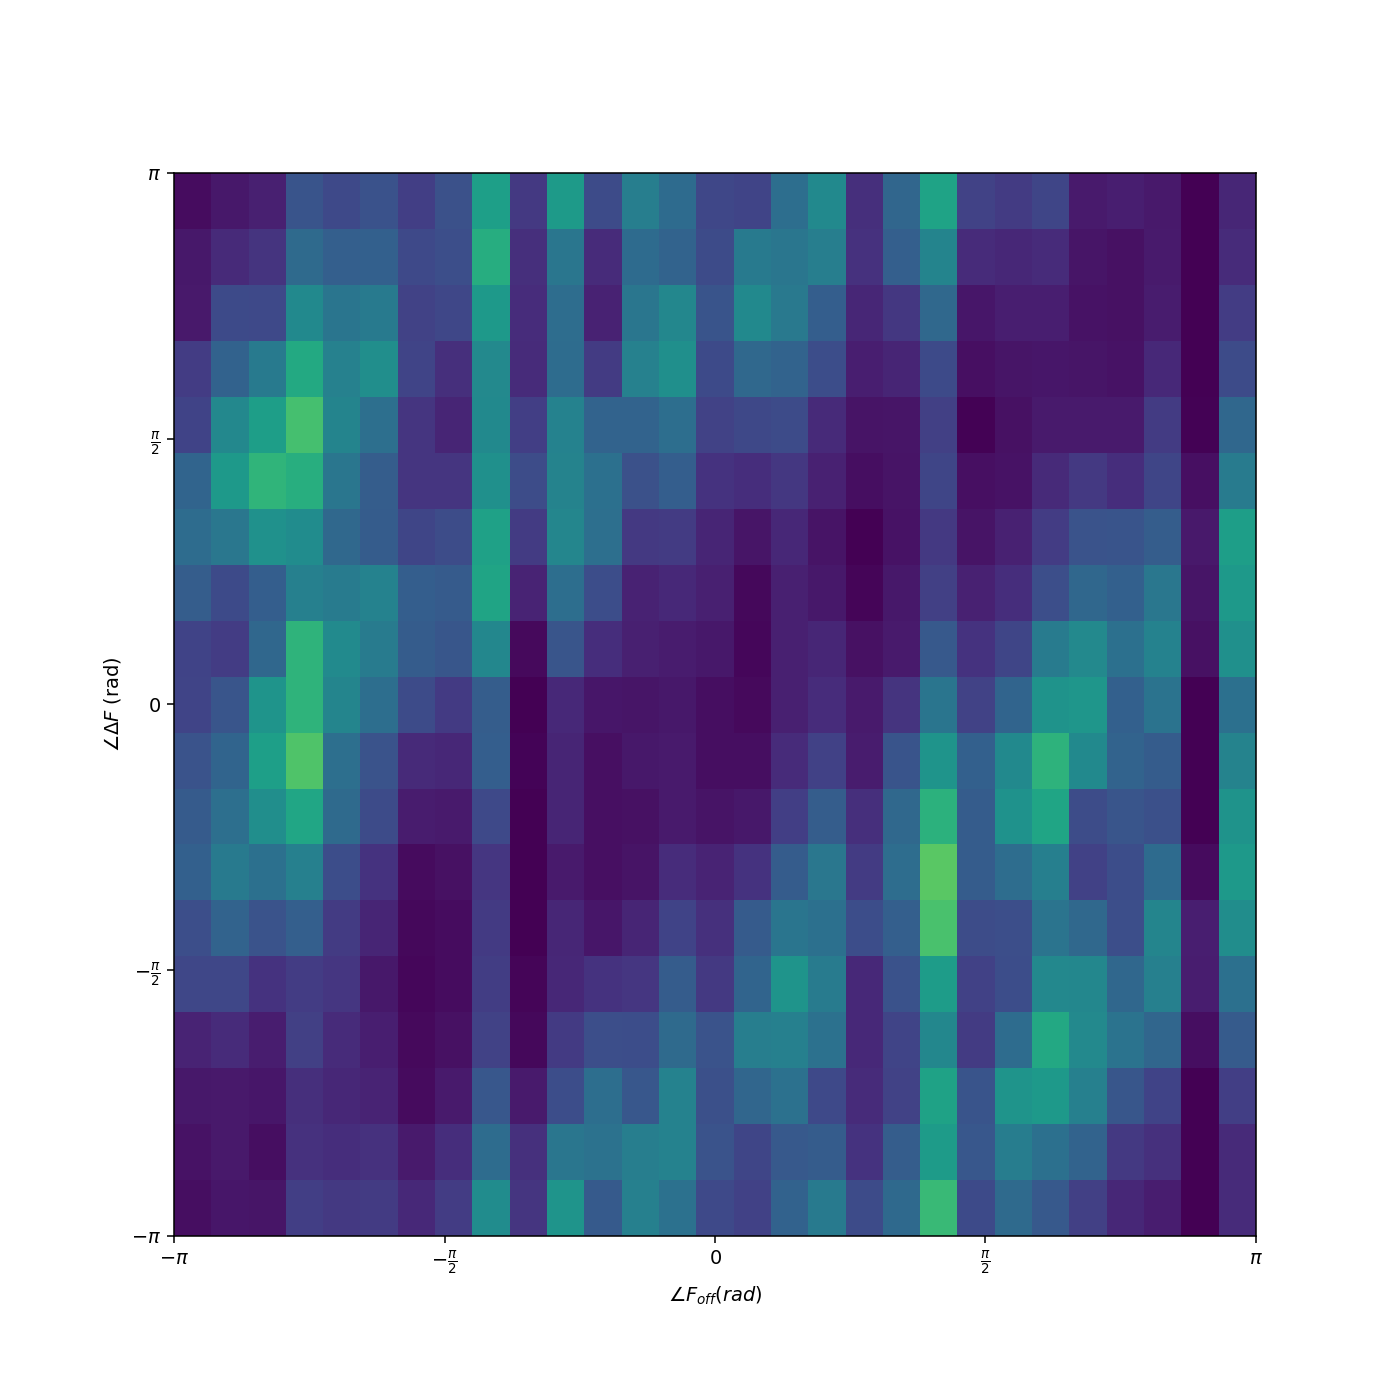

interactive(children=(FloatSlider(value=0.0, description='sigma_level', max=3.0, min=-3.0), Output()), _dom_cl…

In [10]:
x = np.angle(Foff[:,None]*np.ones(DeltaF.shape)).flatten()
y = np.angle(DeltaF).flatten()
mag = (np.abs(Fon) - np.abs(Foff)[:,None]).flatten()
sigma = (mag - np.mean(mag))/np.std(mag)


nx = 30
ny = 20
xbins = np.linspace(-np.pi, np.pi, nx)
ybins = np.linspace(-np.pi, np.pi, ny)


H, xbins, ybins = np.histogram2d(x, y, (xbins,ybins))
plt.figure(figsize=(10,10))
im = plt.imshow(H.T, origin='lower', aspect=nx/ny)

xmin,xmax = plt.xlim()

plt.xticks([
    1.00*xmin + 0.00*xmax,
    0.75*xmin + 0.25*xmax,
    0.5*xmin + 0.5*xmax,
    0.25*xmin + 0.75*xmax,
    0.00*xmin + 1.00*xmax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)

ymin,ymax = plt.ylim()

plt.yticks([
    1.00*ymin + 0.00*ymax,
    0.75*ymin + 0.25*ymax,
    0.5*ymin + 0.5*ymax,
    0.25*ymin + 0.75*ymax,
    0.00*ymin + 1.00*ymax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)


plt.xlabel(r"$\angle F_{off} (rad)$")
plt.ylabel(r"$\angle \Delta F$ (rad)")

delta = 1.0 #Height of z slice
@interact(sigma_level=(-3, 3, 0.1))
def update(sigma_level=0.):
    H,_,_ = np.histogram2d(
        x[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        y[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        (xbins, ybins)
    )
    return im.set_data(H.T)

<IPython.core.display.Javascript object>


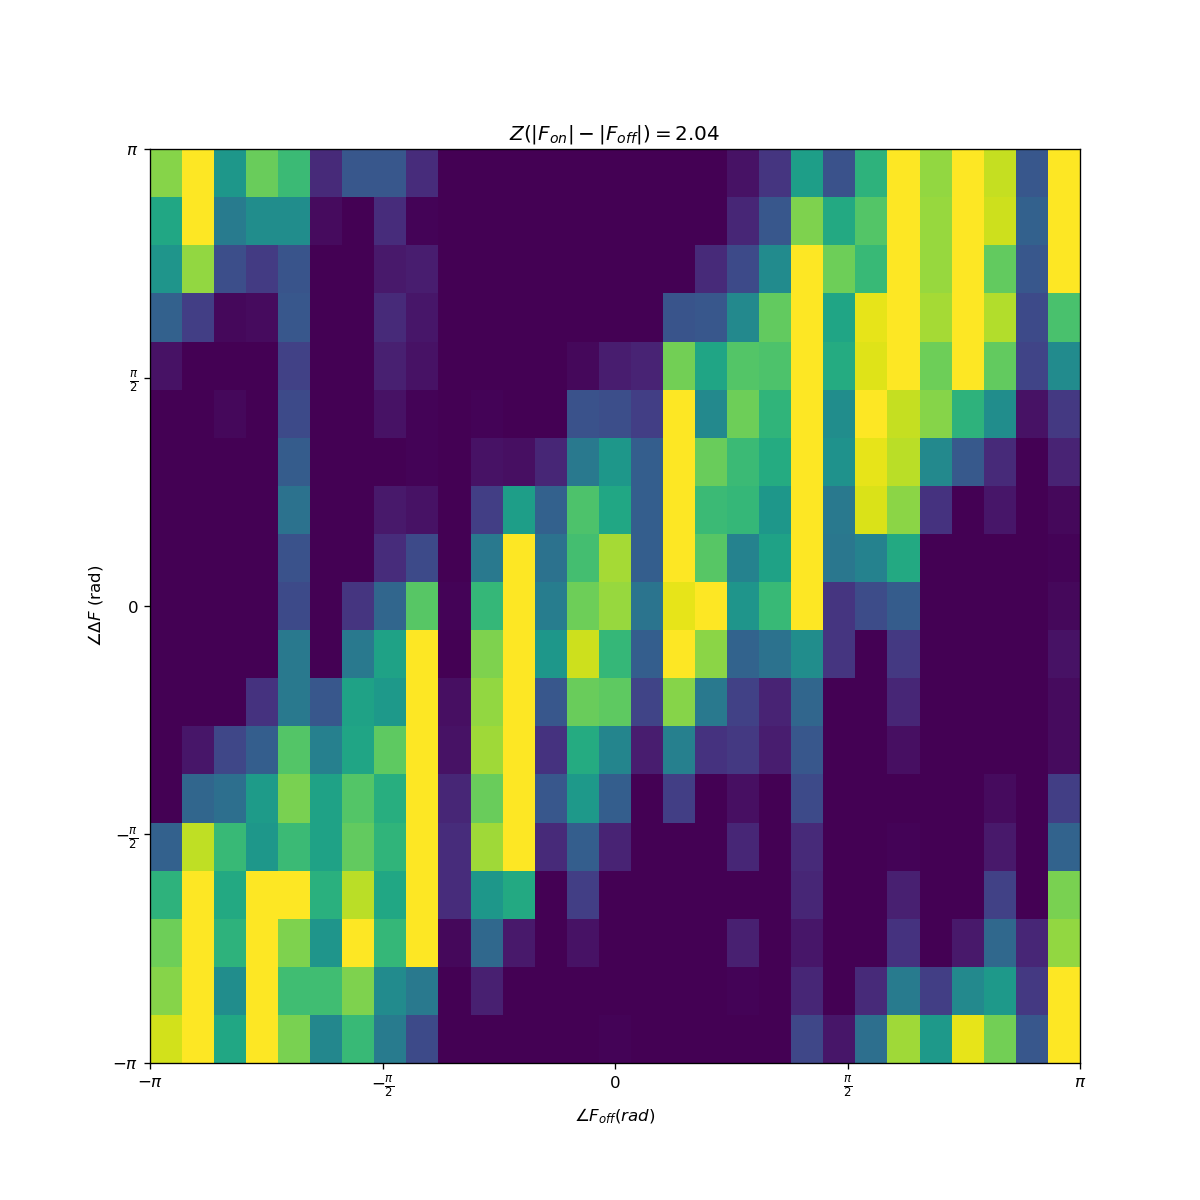

In [23]:
x = np.angle(Foff[:,None]*np.ones(DeltaF.shape)).flatten()
y = np.angle(DeltaF).flatten()
mag = (np.abs(Fon) - np.abs(Foff)[:,None]).flatten()
sigma = (mag - np.mean(mag))/np.std(mag)


nx = 30
ny = 20
xbins = np.linspace(-np.pi, np.pi, nx)
ybins = np.linspace(-np.pi, np.pi, ny)


H, xbins, ybins = np.histogram2d(x, y, (xbins,ybins), normed=True)
f = plt.figure(figsize=(10,10))
im = plt.imshow(H.T, origin='lower', aspect=nx/ny)

xmin,xmax = plt.xlim()

plt.xticks([
    1.00*xmin + 0.00*xmax,
    0.75*xmin + 0.25*xmax,
    0.5*xmin + 0.5*xmax,
    0.25*xmin + 0.75*xmax,
    0.00*xmin + 1.00*xmax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)

ymin,ymax = plt.ylim()

plt.yticks([
    1.00*ymin + 0.00*ymax,
    0.75*ymin + 0.25*ymax,
    0.5*ymin + 0.5*ymax,
    0.25*ymin + 0.75*ymax,
    0.00*ymin + 1.00*ymax,
],[
    r"$-\pi$",
    r"$-\frac{\pi} {2}$",
    r"$0$",
    r"$\frac{\pi} {2}$",
    r"$\pi$",
]
)


plt.xlabel(r"$\angle F_{off} (rad)$")
plt.ylabel(r"$\angle \Delta F$ (rad)")
nframes=500
delta = 1.0 #Height of z slice
def update(i):
    sigma_level = np.linspace(-3, 3, nframes)[i]
    plt.title(f"$Z(|F_{{on}}| - |F_{{off}}|)=${sigma_level:1.2f}")
    H,_,_ = np.histogram2d(
        x[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        y[(sigma>sigma_level-delta) & (sigma<sigma_level + delta)],
        (xbins, ybins),
        normed=True
    )
    im.set_data(H.T)
    return im

from IPython.display import HTML
from matplotlib import animation
anim = animation.FuncAnimation(f, update, frames=nframes, interval=20)

Text(0, 0.5, '$|\\Delta F|$ Error')

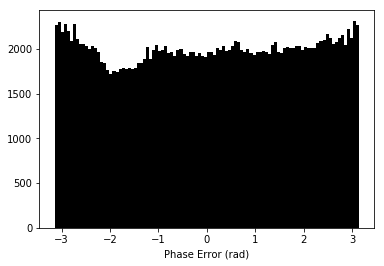

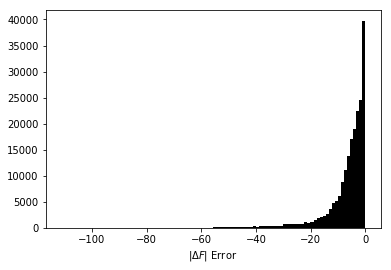

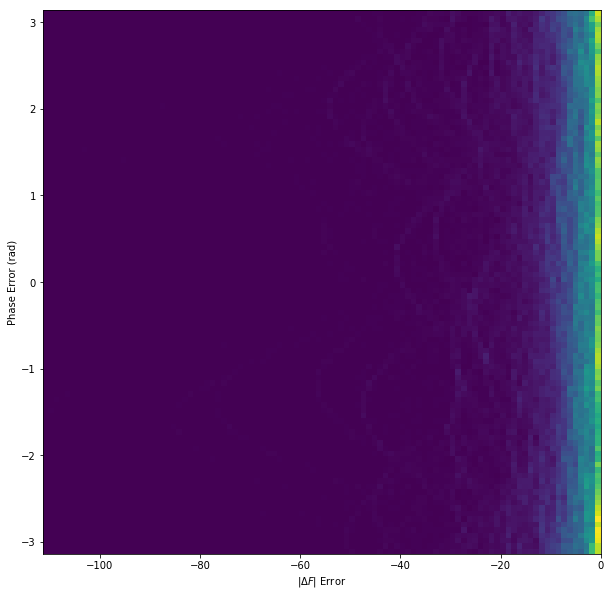

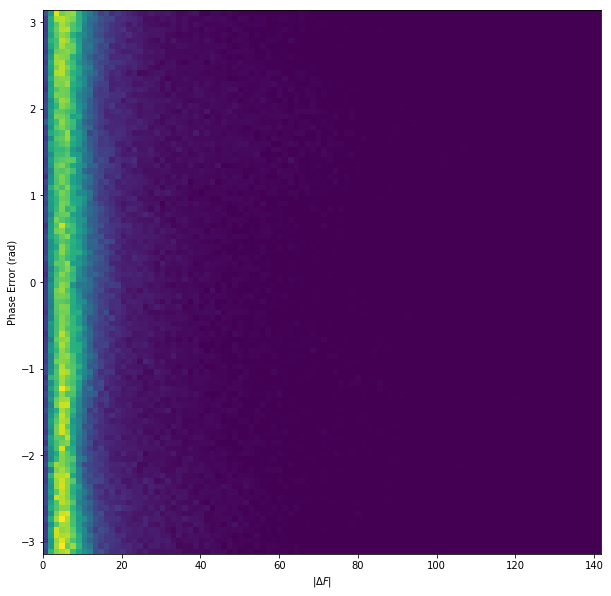

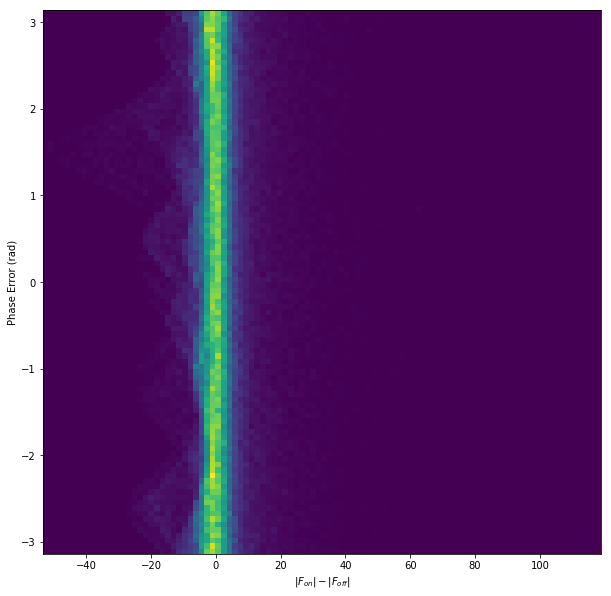

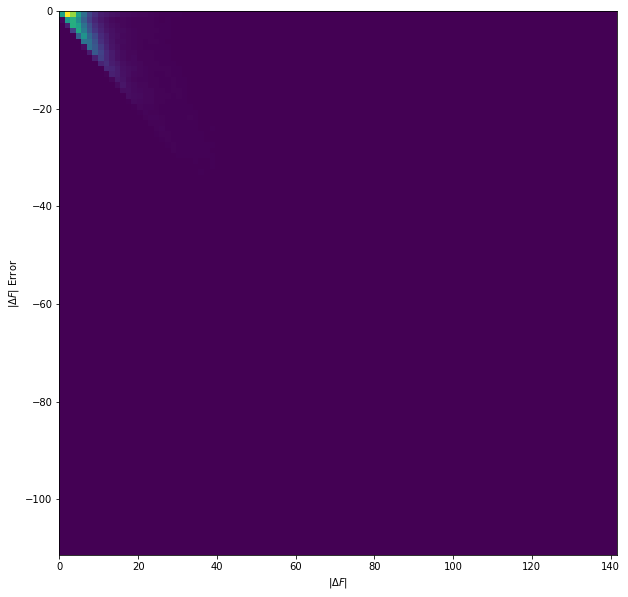

In [335]:
fobs = np.abs(Fon) - np.abs(Foff)[:,None]
phobs = (fobs < 0.)*np.pi + np.angle(Foff)[:,None]
pherr = np.angle(np.exp(1j*phobs)*np.exp(1j*np.angle(DeltaF)))
_ = plt.hist(pherr.flatten(), 100, color='k')
plt.xlabel('Phase Error (rad)')

plt.figure()
ferr = np.abs(np.abs(Fon) - np.abs(Foff)[:,None]) - np.abs(DeltaF)
_ = plt.hist(ferr.flatten(), 100, color='k')
plt.xlabel('$|\Delta F|$ Error')

plt.figure(figsize=(10,10))
plt.hist2d(ferr.flatten(), pherr.flatten(), 100)
plt.xlabel('$|\Delta F|$ Error')
plt.ylabel('Phase Error (rad)')


plt.figure(figsize=(10,10))
plt.hist2d(np.abs(DeltaF).flatten(), pherr.flatten(), 100)
plt.xlabel('$|\Delta F|$')
plt.ylabel('Phase Error (rad)')

plt.figure(figsize=(10,10))
plt.hist2d(fobs.flatten(), pherr.flatten(), 100)
plt.xlabel('$|F_{on}| - |F_{off}|$')
plt.ylabel('Phase Error (rad)')


plt.figure(figsize=(10,10))
plt.hist2d(np.abs(DeltaF).flatten(), ferr.flatten(), 100)
plt.xlabel('$|\Delta F|$')
plt.ylabel('$|\Delta F|$ Error')

Text(0.5, 0, '$\\Delta \\phi$')

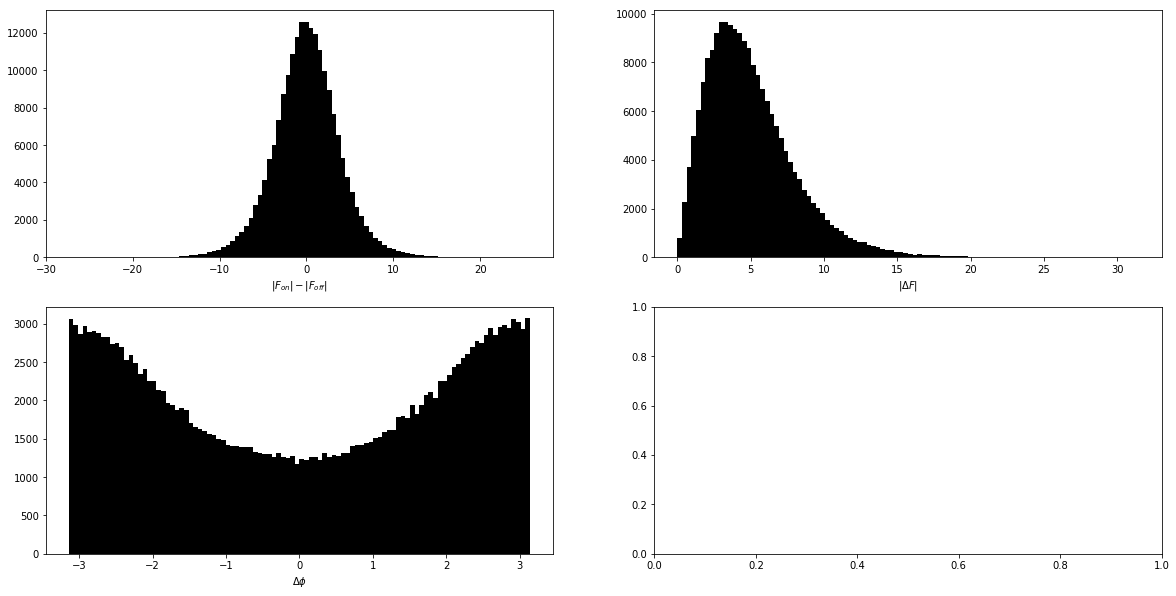

In [424]:


f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))

plt.sca(ax1)
plt.hist((np.abs(Fon) - np.abs(Foff)[:,None]).flatten(), 100, color='k')
plt.xlabel("$|F_{on}| - |F_{off}|$")

plt.sca(ax2)
plt.hist(np.abs(Fon - Foff[:,None]).flatten(), 100, color='k')
plt.xlabel("$|\Delta F|$")

plt.sca(ax3)
plt.hist(np.angle(DeltaF*np.exp(-1j*np.angle(Foff))[:,None]).flatten(), 100, color='k')
plt.xlabel("$\Delta \phi$")



Median: 0.03024906892941383
Mean: 0.4042414185753754


Text(0, 0.5, '$\\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$')

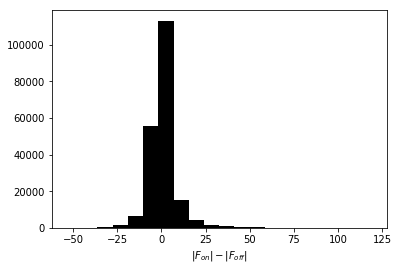

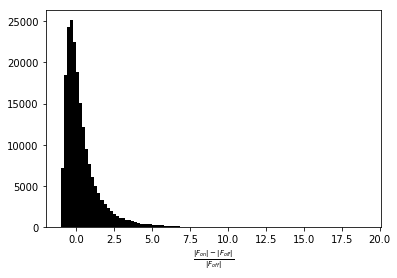

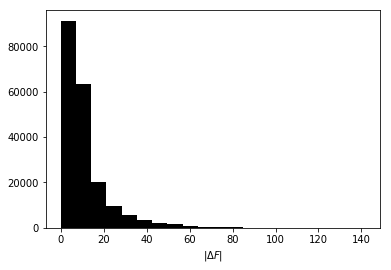

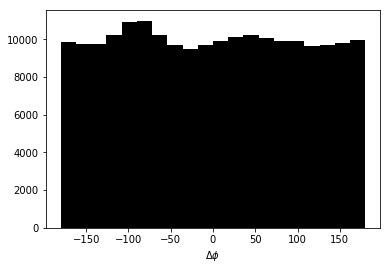

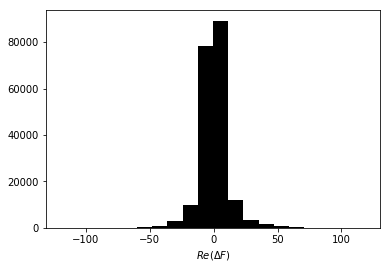

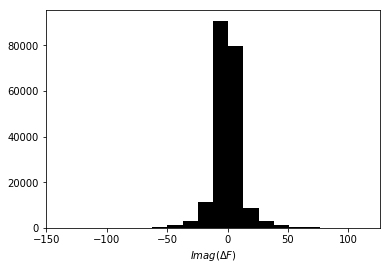

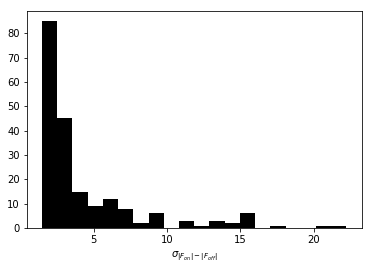

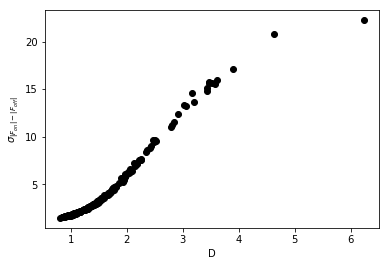

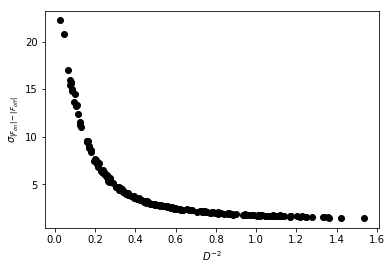

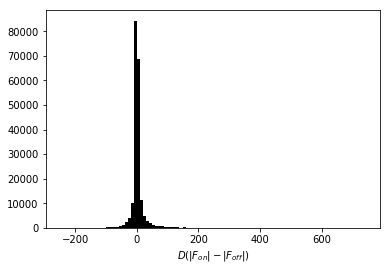

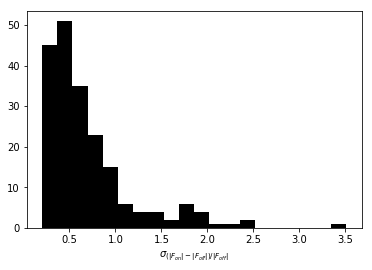

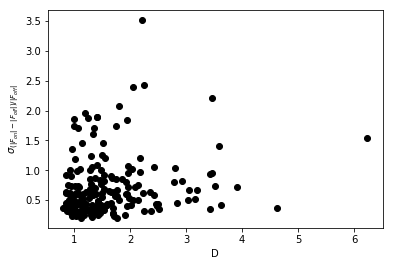

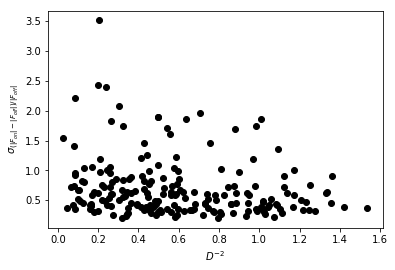

In [337]:


plt.figure()
plt.hist((np.abs(Fon) - np.abs(Foff)[:,None]).flatten(), 20, color='k')
plt.xlabel("$|F_{on}| - |F_{off}|$")

DeltaFoverF = (((np.abs(Fon) - np.abs(Foff)[:,None]))/(np.abs(Foff)[:,None])).flatten()
print(f"Median: {np.median(DeltaFoverF)}")
print(f"Mean: {DeltaFoverF.mean()}")
plt.figure()
plt.hist((((np.abs(Fon) - np.abs(Foff)[:,None]))/(np.abs(Foff)[:,None])).flatten(), 100, color='k')
plt.xlabel(r"$\frac {|F_{on}| - |F_{off}|}{|F_{off}|}$")

plt.figure()
plt.hist(np.abs(DeltaF).flatten(), 20, color='k')
plt.xlabel("$|\Delta F|$")
plt.figure()
plt.hist(np.rad2deg(np.angle(DeltaF)).flatten(), 20, color='k')
plt.xlabel("$\Delta \phi$")
plt.figure()
plt.hist(np.real(DeltaF).flatten(), 20, color='k')
plt.xlabel("$Re(\Delta F)$")
plt.figure()
plt.hist(np.imag(DeltaF).flatten(), 20, color='k')
plt.xlabel("$Imag(\Delta F)$")


std = (np.abs(Fon) - np.abs(Foff)[:,None]).std(1)
plt.figure()
plt.hist(std, 20, color='k')
plt.xlabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.plot(D, std, 'ko')
plt.xlabel("D")
plt.ylabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.plot(D**-2, std, 'ko')
plt.xlabel("$D^{-2}$")
plt.ylabel("$\sigma_{|F_{on}| - |F_{off}|}$")

plt.figure()
plt.hist((D[:,None]*(np.abs(Fon) - np.abs(Foff)[:,None])).flatten(), 100, color='k')
plt.xlabel("$D (|F_{on}| - |F_{off}|)$")


std = ((np.abs(Fon) - np.abs(Foff)[:,None])/np.abs(Foff)[:,None]).std(1)
plt.figure()
plt.hist(std, 20, color='k')
plt.xlabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

plt.figure()
plt.plot(D, std, 'ko')
plt.xlabel("D")
plt.ylabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

plt.figure()
plt.plot(D**-2, std, 'ko')
plt.xlabel("$D^{-2}$")
plt.ylabel("$\sigma_{(|F_{on}| - |F_{off}|)/|F_{off}|}$")

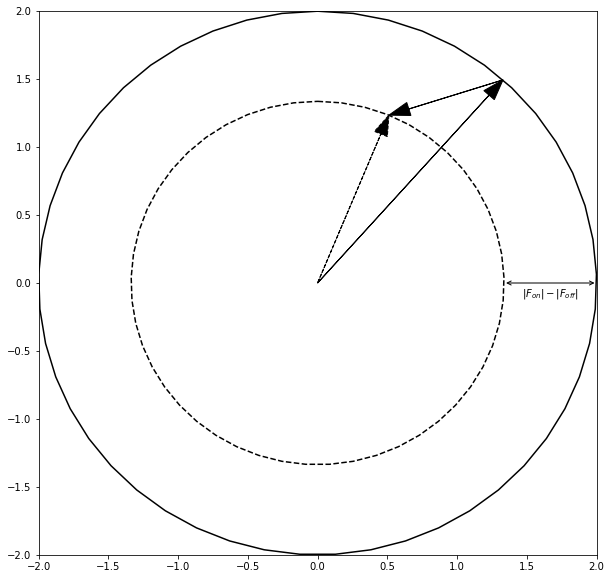

In [210]:
Foff = 2*np.exp(2j*np.pi*np.random.random())
DeltaF = np.random.normal(1.0, 0.1)*np.exp(1j*(2*np.pi*np.random.random()))
Fon = Foff + DeltaF

plt.figure(figsize=(10,10))
plt.arrow(0., 0., np.real(Foff), np.imag(Foff), color='k', length_includes_head=True, head_width=0.1)
plt.arrow(0., 0., np.real(Fon), np.imag(Fon), color='k', linestyle='--', length_includes_head=True, head_width=0.1)
plt.arrow(np.real(Foff), np.imag(Foff), np.real(DeltaF), np.imag(DeltaF), color='k', length_includes_head=True, head_width=0.1)
lim = np.max([
    np.abs(Foff),
    np.abs(Fon),
])
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))

plt.plot(
    np.abs(Foff)*np.sin(np.linspace(0, 2*np.pi)),
    np.abs(Foff)*np.cos(np.linspace(0, 2*np.pi)),
    '-k',
)

plt.plot(
    np.abs(Fon)*np.sin(np.linspace(0, 2*np.pi)),
    np.abs(Fon)*np.cos(np.linspace(0, 2*np.pi)),
    '--k',
)

plt.annotate(s='', xy=(
    np.min((np.abs(Fon), np.abs(Foff))), 0,
), xytext=(
    np.max((np.abs(Fon), np.abs(Foff))), 0,
), arrowprops=dict(arrowstyle='<->'))

plt.text(
    np.mean((np.abs(Fon), np.abs(Foff))), -0.1,
    r'$|F_{on}| - |F_{off}|$', horizontalalignment='center'
)


    

plt.show()